In [173]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [174]:
import math
import torch
from torch import nn

In [175]:
# %reset

In [176]:
device = 'cuda: 0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [177]:
num_heads = 8
embed_len = 512
batch_size = 8
stack_len = 6 # number of encoder and decoder
dropout = 0.1

output_vocab_size = 7000
input_vocab_size = 7000

Building the embedding model

In [178]:
class InputEmbedding(nn.Module):
    def __init__(self, input_vocab_size = input_vocab_size, embed_len=embed_len, dropout=dropout, device=device):
        super(InputEmbedding, self).__init__()
        self.input_vocab_size = input_vocab_size
        self.embed_len = embed_len
        self.dropout =dropout
        self.device = device
        
        self.firstEmbedding = nn.Embedding(self.input_vocab_size, self.embed_len) # first embedding layer
        self.secondEmbedding = nn.Embedding(self.input_vocab_size, self.embed_len) # positinal Embedding layer
        
        self.dropoutLayer = nn.Dropout(p=self.dropout)
        
        
    def forward(self, input):
        first_embedding = self.firstEmbedding(input)
        batch_size, seq_len = input.shape
        
        position_vector = torch.arange(0,seq_len).expand(batch_size, seq_len).to(self.device)
        positional_embedding = self.secondEmbedding(position_vector)
        
        return self.dropoutLayer(first_embedding + positional_embedding)

In [179]:
input_test = torch.randint(10,(8,20)).to(device)
print(input_test.size())
print(input_test)

torch.Size([8, 20])
tensor([[8, 2, 5, 1, 8, 0, 4, 4, 5, 2, 0, 1, 7, 1, 2, 2, 9, 4, 5, 0],
        [2, 7, 0, 2, 4, 6, 6, 9, 2, 7, 9, 0, 3, 6, 4, 3, 4, 7, 1, 5],
        [1, 3, 2, 9, 1, 6, 3, 0, 1, 9, 5, 1, 0, 6, 1, 3, 9, 7, 8, 2],
        [5, 2, 8, 4, 0, 9, 0, 5, 1, 4, 8, 2, 9, 8, 3, 2, 9, 8, 5, 2],
        [2, 7, 0, 0, 1, 2, 9, 0, 1, 2, 2, 7, 1, 2, 4, 3, 5, 7, 8, 3],
        [5, 4, 0, 9, 9, 2, 1, 1, 4, 0, 9, 8, 3, 5, 3, 0, 6, 2, 6, 6],
        [6, 8, 7, 3, 2, 1, 8, 8, 5, 3, 1, 9, 0, 5, 7, 3, 6, 9, 7, 0],
        [1, 3, 1, 2, 2, 5, 5, 8, 6, 2, 6, 6, 6, 2, 1, 0, 6, 6, 6, 4]])


In [180]:
embedding_layer = InputEmbedding().to(device)
output = embedding_layer.forward(input_test)
print(output.size())

torch.Size([8, 20, 512])


In [181]:
# print(output)

Building The Scale Dot Product

In [182]:
class ScaleDotProduct(nn.Module):
    def __init__(self, embed_len = embed_len, mask = None):
        super(ScaleDotProduct, self).__init__()
        self.embed_len =  embed_len
        self.mask = mask
        self.dk = embed_len

        self.softmax = nn.Softmax(dim=3)
            
    def forward(self, queries, keys, values):
        compatibilty = torch.matmul(queries, torch.transpose(keys, 2, 3))
        compatibilty = compatibilty / math.sqrt(self.dk)
        
        compatibilty = self.softmax(compatibilty)
        
        # apply mask for the decoder
        if self.mask is not None:
            compatibilty = torch.tril(compatibilty)
        
        return torch.matmul(compatibilty, torch.transpose(values,1,2))

In [183]:
ScaleDotProduct()

ScaleDotProduct(
  (softmax): Softmax(dim=3)
)

Building Multi-Headed Block

In [184]:
class MultiHeadAttention(nn.Module):
    def __init__(self,num_heads = num_heads, embed_len = embed_len, batch_size = batch_size, mask=None):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_len = embed_len
        self.batch_size = batch_size
        self.mask = mask
        self.head_length = int(self.embed_len/self.num_heads)
        
        self.q_in = self.k_in = self.v_in = self.embed_len
        
        # Linear layers as input to multiheaded attention
        # they have input dim = 512 abd output dim = 512
        self.q_linear = nn.Linear(int(self.q_in), int(self.q_in))
        self.k_linear = nn.Linear(int(self.k_in), int(self.k_in))
        self.v_linear = nn.Linear(int(self.v_in), int(self.v_in))
        
        # activate mask for decoder
        if self.mask is not None:
            self.attention = ScaleDotProduct(mask=True)
        else:
            self.attention = ScaleDotProduct()
        
        # final output layer
        self.output_linear = nn.Linear(self.q_in, self.q_in)
        
    def forward(self, query, keys, values):
        
        # query shape {8, 25, 512}
        # we need to reshape (batch_size, seq_len, embed_len) to (batch_size, seq_len, num_heads, head_length)
        # output should be reshape into (8, 20, 8, 64)
        queries = self.k_linear(query).reshape(self.batch_size, -1, self.num_heads, self.head_length)
        
        queries = queries.transpose(1,2)
        
        # key shape = (batch_size, num_heads, seq_len, head_length)
        keys = self.q_linear(keys).reshape(self.batch_size, -1, self.num_heads, self.head_length)
        keys = keys.transpose(1,2)
        
        # value shape = (batch_size, num_heads, seq_len, head_length)
        values = self.v_linear(values).reshape(self.batch_size, -1, self.num_heads, self.head_length)
        
        # qk result dimension (batch_size, num_heads, seq_len, seq_len)  -> (8, 8, 20, 20)
        # qk mutnul V -> (8, 8, 20, 20) matmul (8, 8, 20, 20) = (8, 8, 20, 64) 
        # final shape should be (batch_size, seq_len, seq_len)
        sdp_output = self.attention.forward(queries, keys, values).reshape(
            self.batch_size, -1, self.num_heads*self.head_length)
        
        # output has size (8, 20, 512)
        return self.output_linear(sdp_output)

In [185]:
MultiHeadAttention()

MultiHeadAttention(
  (q_linear): Linear(in_features=512, out_features=512, bias=True)
  (k_linear): Linear(in_features=512, out_features=512, bias=True)
  (v_linear): Linear(in_features=512, out_features=512, bias=True)
  (attention): ScaleDotProduct(
    (softmax): Softmax(dim=3)
  )
  (output_linear): Linear(in_features=512, out_features=512, bias=True)
)

Bulding the Encoder Block

In [186]:
class EncoderBlock(nn.Module):
    def __init__(self, embed_len = embed_len, dropout = dropout):
        super(EncoderBlock,self).__init__()
        self.embed_len = embed_len
        self.dropout = dropout
        self.multihead = MultiHeadAttention()
        self.firstNorm = nn.LayerNorm(self.embed_len)
        self.secondNorm = nn.LayerNorm(self.embed_len)
        self.dropout = nn.Dropout(p=self.dropout)
        
        self.feedforward = nn.Sequential(
            nn.Linear(self.embed_len, self.embed_len*4),
            nn.ReLU(),
            nn.Linear(self.embed_len*4, self.embed_len)
        )
        
        
    def forward(self, queries, keys, values):
        attention_output = self.multihead.forward(queries, keys, values)
        first_sublayer_output = self.firstNorm(attention_output + queries)
        
        
        ## ff - feed forward
        ff_output = self.feedforward(first_sublayer_output)
        ff_output = self.dropout(ff_output)
        
        return self.secondNorm(ff_output + first_sublayer_output)

In [187]:
EncoderBlock()

EncoderBlock(
  (multihead): MultiHeadAttention(
    (q_linear): Linear(in_features=512, out_features=512, bias=True)
    (k_linear): Linear(in_features=512, out_features=512, bias=True)
    (v_linear): Linear(in_features=512, out_features=512, bias=True)
    (attention): ScaleDotProduct(
      (softmax): Softmax(dim=3)
    )
    (output_linear): Linear(in_features=512, out_features=512, bias=True)
  )
  (firstNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (secondNorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (feedforward): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
  )
)

Building The Decoder Block

In [188]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_len = embed_len):
        super(DecoderBlock, self).__init__()
        self.embed_len = embed_len
        self.dropout = dropout
        
        self.maskedMultihead = MultiHeadAttention(mask=True)
        self.firstNorm = nn.LayerNorm(self.embed_len)
        self.dropoutLayer = nn.Dropout(p=self.dropout)
        
        self.encoderBlock = EncoderBlock()
        
    def forward(self, queries, keys, values):
        maskedMultihead_output = self.maskedMultihead(queries, queries, queries)
        maskedMultihead_output = self.dropoutLayer(maskedMultihead_output)
        first_sublayer_output = self.firstNorm(maskedMultihead_output + queries)
        
        return self.encoderBlock(first_sublayer_output, keys, values)

### Implement Complete Transformer

In [189]:
class Transformer(nn.Module):
    def __init__(self, embed_len = embed_len, stack_len = stack_len, device = device, output_vocab_size = output_vocab_size):
        super(Transformer, self).__init__()
        self.embed_len = embed_len
        self.stack_len = stack_len
        self.device = device
        self.output_vocab_size = output_vocab_size
        
        self.embedding = InputEmbedding().to(self.device)
        self.encStack = nn.ModuleList(EncoderBlock() for i in range(self.stack_len))
        self.decStack = nn.ModuleList(DecoderBlock() for i in range(self.stack_len))
        
        self.finalLinear = nn.Linear(self.embed_len, self.output_vocab_size).to(self.device)
        
        self.softmax = nn.Softmax()
        

    def forward(self, test_input, test_output):
        enc_output = self.embedding(test_input)
        
        for enc_layer in self.encStack:
            enc_output = enc_layer.forward(enc_output, enc_output, enc_output)
        
        dec_output = self.embedding(test_output)
        for dec_layer in self.decStack:
            dec_output = dec_layer.forward(dec_output, enc_output, enc_output)
            
        final_output = self.finalLinear(dec_output)
        
        return self.softmax(final_output)

In [190]:
input_tokens = torch.randint(10,(batch_size,30)).to(device)
input_tokens.size()

torch.Size([8, 30])

In [191]:
output_target = torch.randint(10,(batch_size,20)).to(device)
output_target.size()

torch.Size([8, 20])

In [192]:
transformer = Transformer().to(device)
transformer_output = transformer.forward(input_tokens, output_target)
transformer_output.size()

C:\Users\Asus\anaconda3\envs\torch2tf2\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([8, 20, 7000])

In [193]:
import torchviz

In [202]:
torchviz.make_dot(transformer_output, params=dict(Transformer().named_parameters()),show_attrs=True, show_saved=True).render("multihead_attention", format="png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.574044 to fit


'multihead_attention.png'

In [201]:
# torchviz.make_dot(transformer_output, params=dict(Transformer().named_parameters()))

### Method - 2 

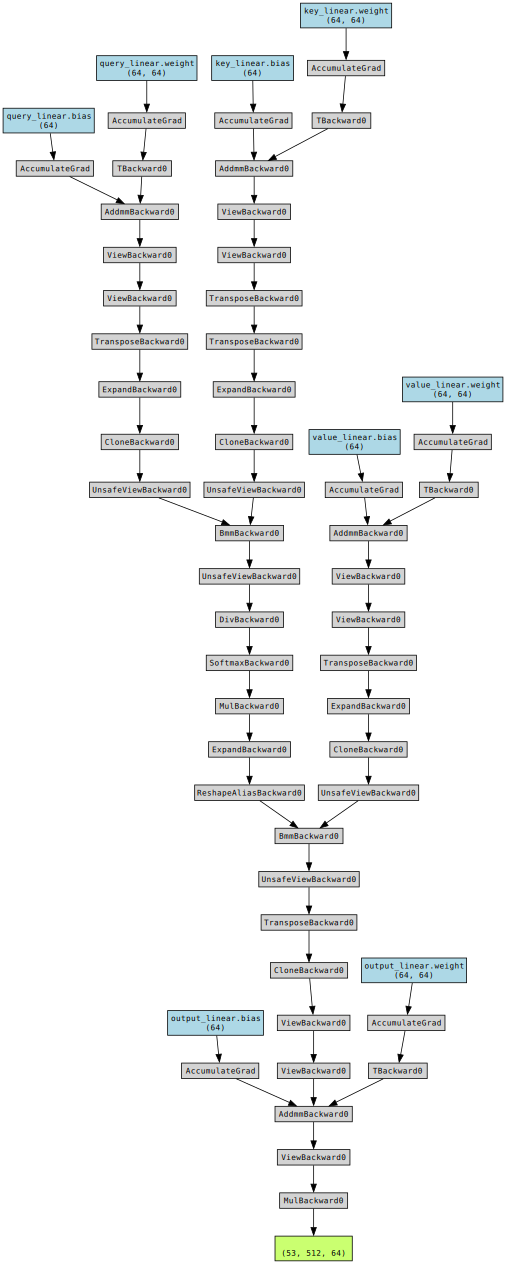

In [169]:
import torch
import torch.nn as nn
import torchviz

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout=0.1):
        super(ScaledDotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention = self.dropout(torch.softmax(scores, dim=-1))
        context = torch.matmul(attention, value)
        
        return context, attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.query_linear = nn.Linear(d_model, d_model)
        self.key_linear = nn.Linear(d_model, d_model)
        self.value_linear = nn.Linear(d_model, d_model)
        self.attention = ScaledDotProductAttention(dropout)
        self.output_linear = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        query = self.query_linear(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        key = self.key_linear(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        value = self.value_linear(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        if mask is not None:
            mask = mask.unsqueeze(1)
        
        context, attention = self.attention(query, key, value, mask)
        
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        output = self.output_linear(context)
        output = self.dropout(output)
        
        return output, attention

input_seq_len = 512
d_model = 64
num_heads = 8
batch_size = 53

query = torch.randn(batch_size, input_seq_len, d_model)
key = torch.randn(batch_size, input_seq_len, d_model)
value = torch.randn(batch_size, input_seq_len, d_model)

multihead_attention = MultiHeadAttention(d_model, num_heads)
output, attention = multihead_attention(query, key, value)

# torchviz.make_dot(output, params=dict(multihead_attention.named_parameters())).render("multihead_attention", format="png")
torchviz.make_dot(output, params=dict(multihead_attention.named_parameters()))